In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import Callback,TensorBoard
from tensorflow.keras.optimizers import SGD
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
np.random.seed(1213)

In [3]:
class TrainingHistory(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0

    def on_epoch_end(self,epoch,logs={}):
        self.losses.append(logs.get("loss"))
        self.valid_losses.append(logs.get("val_loss"))
        self.accs.append(logs.get("accs"))
        self.valid_accs.append(logs.get("valid_accs"))
        self.epoch += 1

history = TrainingHistory()

In [4]:
model = Sequential()
model.add(Dense(10,input_shape=(2,)))
model.add(Activation("tanh"))
model.add(Dense(1))
model.add(Activation("tanh"))

model.compile(loss='mean_squared_error', 
                optimizer=SGD(learning_rate=0.1,momentum=0.001,nesterov=True), 
                metrics=['accuracy'])

In [5]:
nb_samples = 200
valid_split = 0.2
test_split = 0.1
samples = np.zeros(nb_samples, dtype=[('input', float, 2),('output', float, 1)])

C:\Users\hajna\AppData\Local\Temp/ipykernel_12148/3446958447.py:4: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  samples = np.zeros(nb_samples, dtype=[('input', float, 2),('output', float, 1)])


In [6]:
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2 + noise[0], -2 + noise[1]), 0
    samples[i + 1] = (2 + noise[2], -2 + noise[3]), 1
    samples[i + 2] = (-2 + noise[4], 2 + noise[5]), 1
    samples[i + 3] = (2 + noise[6], 2 + noise[7]), 0

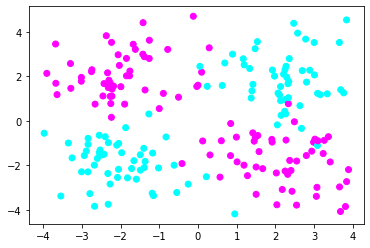

In [7]:
fig1 = plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:],cmap=plt.cm.cool)

In [8]:
samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]

In [9]:
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
scaler

StandardScaler()

In [10]:
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

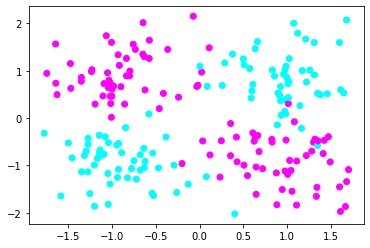

In [11]:
fig1 = plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:],cmap=plt.cm.cool)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
patience=10
early_stopping = EarlyStopping(patience=patience,verbose=1)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='weights.hdf5',save_best_only=True, verbose=1)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=20,min_lr=10e-5)

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result = 0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=0.001
    if (epoch>60):
        result=0.0005
    print('learning rate: {}'.format(result))
    return result
        
change_lr = LearningRateScheduler(scheduler)

In [16]:
tensorboard_callback = TensorBoard(log_dir='./logs',write_graph=True,histogram_freq=1)

In [17]:
model.fit(samples_train['input'],samples_train['output'],
          batch_size=20,
          epochs=2500,
          verbose=2,
          validation_data=(samples_valid['input'],samples_valid['output']),
          callbacks=[reduce_lr,checkpoint,early_stopping,history,tensorboard_callback],
          shuffle=True)

Epoch 1/2500
7/7 - 1s - loss: 0.7283 - accuracy: 0.6214 - val_loss: 0.3925 - val_accuracy: 0.6500

Epoch 00001: val_loss improved from inf to 0.39255, saving model to weights.hdf5
Epoch 2/2500
7/7 - 0s - loss: 0.2873 - accuracy: 0.4929 - val_loss: 0.2527 - val_accuracy: 0.5500

Epoch 00002: val_loss improved from 0.39255 to 0.25267, saving model to weights.hdf5
Epoch 3/2500
7/7 - 0s - loss: 0.2454 - accuracy: 0.5500 - val_loss: 0.2348 - val_accuracy: 0.4250

Epoch 00003: val_loss improved from 0.25267 to 0.23476, saving model to weights.hdf5
Epoch 4/2500
7/7 - 0s - loss: 0.2300 - accuracy: 0.6000 - val_loss: 0.2195 - val_accuracy: 0.6500

Epoch 00004: val_loss improved from 0.23476 to 0.21953, saving model to weights.hdf5
Epoch 5/2500
7/7 - 0s - loss: 0.2198 - accuracy: 0.7000 - val_loss: 0.2056 - val_accuracy: 0.8750

Epoch 00005: val_loss improved from 0.21953 to 0.20564, saving model to weights.hdf5
Epoch 6/2500
7/7 - 0s - loss: 0.2067 - accuracy: 0.8500 - val_loss: 0.1903 - val_acc

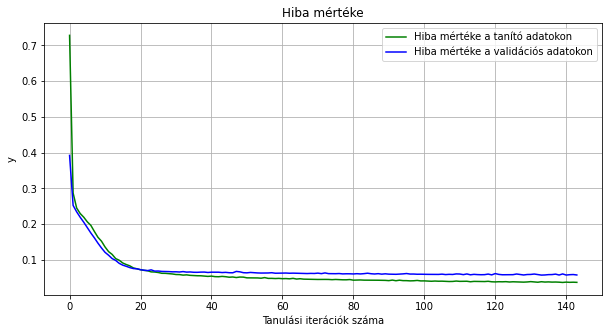

In [18]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Test MSE: 0.074879


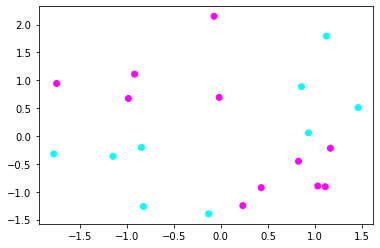

In [19]:
# a legjobb modell visszatöltése
from tensorflow.keras.models import load_model
model = load_model('weights.hdf5')


# teszt adatokkal prediktálás
preds=model.predict(samples_test['input'])
# hiba számítása a teszt adatokon
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))
# predikció megjelenítése
fig1=plt.figure()
plt.scatter(samples_test['input'][:,0], \
            samples_test['input'][:,1], \
            c=np.round(preds[:,0]), cmap=plt.cm.cool)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [21]:
print('Rétegek:\n')
for layer in model.layers:
    print("Réteg neve: ", layer.name, ', tanítható: ', layer.trainable)
    print(layer.get_config(),'\n')

Rétegek:

Réteg neve:  dense , tanítható:  True
{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 10, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

Réteg neve:  activation , tanítható:  True
{'name': 'activation', 'trainable': True, 'dtype': 'float32', 'activation': 'tanh'} 

Réteg neve:  dense_1 , tanítható:  True
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': Non

In [22]:
print("Súlyok:")
i=0
for layer in model.layers:
    print(model.get_layer(index=i).get_weights())
    i=i+1

Súlyok:
[array([[ 0.72058517, -1.1733898 , -0.02273275,  0.1648665 ,  1.1538831 ,
         0.37350315,  0.43792945, -0.3761918 ,  1.0002749 ,  0.02553791],
       [-0.94443285, -1.0666302 ,  0.14286724, -0.20015411,  1.349038  ,
        -0.39162266, -0.77325153, -0.55084956, -0.29017287, -0.14545003]],
      dtype=float32), array([-0.5533469 , -0.7135454 ,  0.2505163 , -0.03955619, -0.59145963,
       -0.0881376 ,  0.5040206 , -0.27196994,  0.54076135,  0.00350795],
      dtype=float32)]
[]
[array([[ 1.1009859 ],
       [-1.1779513 ],
       [ 0.44511074],
       [-0.10052571],
       [-1.1773093 ],
       [ 0.0452108 ],
       [-0.68699694],
       [-0.51824707],
       [-0.8403595 ],
       [-0.01006168]], dtype=float32), array([0.7070001], dtype=float32)]
[]


In [24]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
